In [65]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [66]:
# 2. Import dataset
df = pd.read_csv("marketing_campaign.csv")

In [67]:
# 3. Drop kolom tidak diperlukan
drop_cols = [ 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Dt_Customer' ]

df = df.drop(columns=drop_cols, errors="ignore")


In [68]:
# 4. Hapus data kosong dan duplikat
df = df.dropna(subset=["Income"])
df = df.drop_duplicates()

In [69]:
# 5. Hitung Total Belanja (sum seluruh kolom Mnt*) dan siapkan data clustering
mnt_cols = [c for c in df.columns if c.startswith("Mnt")]
df["Total_Mnt"] = df[mnt_cols].sum(axis=1)
cluster_data = df[["Income", "Total_Mnt"]].copy().astype(float)


In [70]:
# 6. Statistik deskriptif
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Total_Mnt
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,1968.820397,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,607.075361
std,3249.376275,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,602.900476
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,2814.750000,1959.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,69.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,396.500000
75%,8421.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,1048.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,2525.000000


In [71]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Total_Mnt
0,5524,1957,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,1617
1,2174,1954,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,27
2,4141,1965,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,776
3,6182,1984,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,53
4,5324,1981,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,422


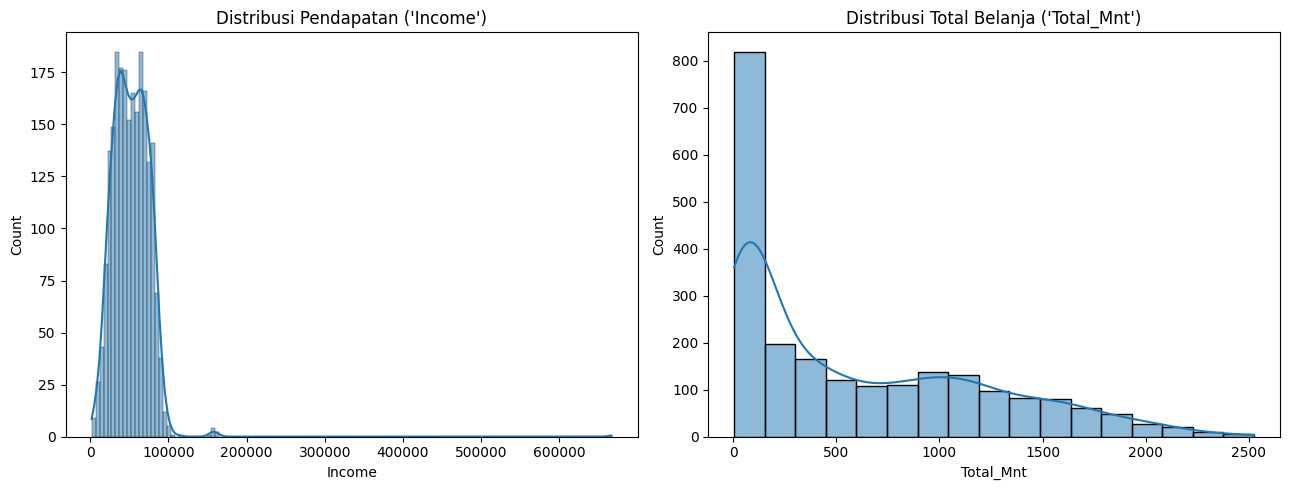

In [72]:
# 7. Visualisasi distribusi kedua fitur
fig, axs = plt.subplots(1,2, figsize=(13,5))
sns.histplot(cluster_data["Income"], kde=True, ax=axs[0])
axs[0].set_title("Distribusi Pendapatan ('Income')")
sns.histplot(cluster_data["Total_Mnt"], kde=True, ax=axs[1])
axs[1].set_title("Distribusi Total Belanja ('Total_Mnt')")
plt.tight_layout()
plt.show()

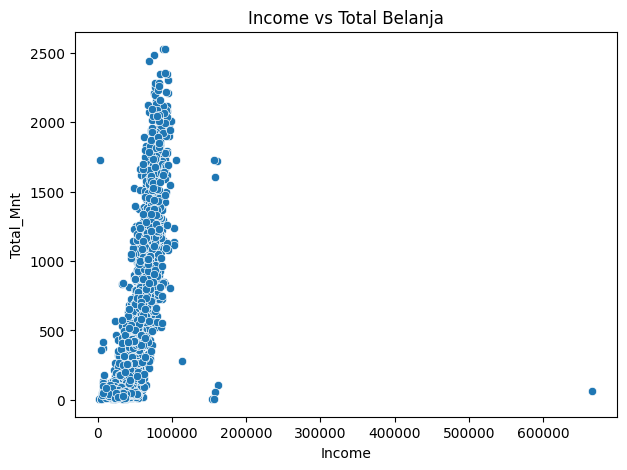

In [73]:
# 8. Scatter plot antara income vs total belanja
plt.figure(figsize=(7,5))
sns.scatterplot(x="Income", y="Total_Mnt", data=cluster_data)
plt.title("Income vs Total Belanja")
plt.show()

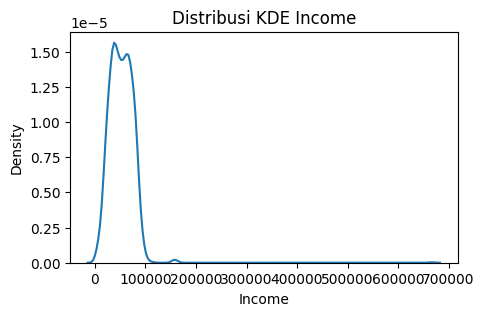

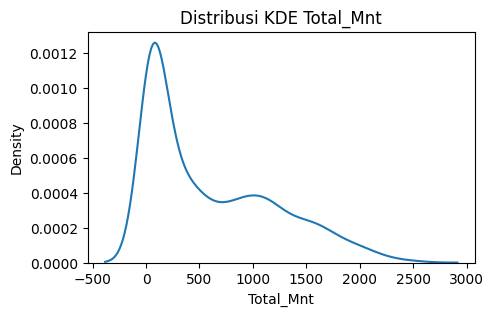

In [74]:
# 9. Visualisasi Hubungan kedua variabel
for col in ["Income", "Total_Mnt"]:
    plt.figure(figsize=(5,3))
    sns.kdeplot(cluster_data[col])
    plt.title(f'Distribusi KDE {col}')
    plt.show()

In [75]:
# 10. Standardisasi kedua fitur untuk clustering
scaler = StandardScaler()
X = scaler.fit_transform(cluster_data)
X_df = pd.DataFrame(X, columns=["Income", "Total_Mnt"])

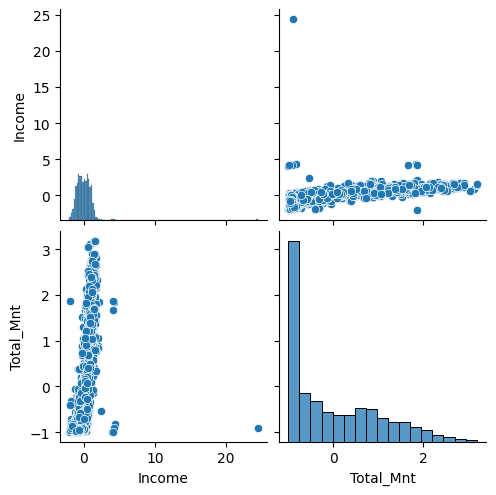

In [76]:
# 11. Visualisasi pairplot kedua fitur (hasil scaling)
sns.pairplot(X_df)
plt.show()

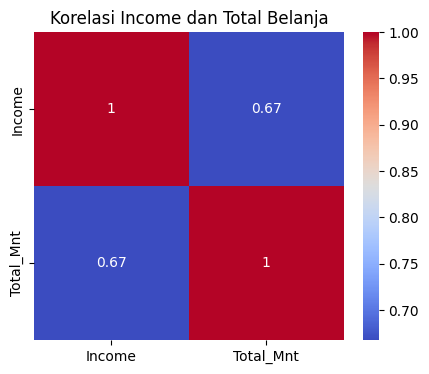

In [77]:
# 12. Korelasi antara kedua fitur saja
plt.figure(figsize=(5,4))
sns.heatmap(cluster_data.corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi Income dan Total Belanja")
plt.show()

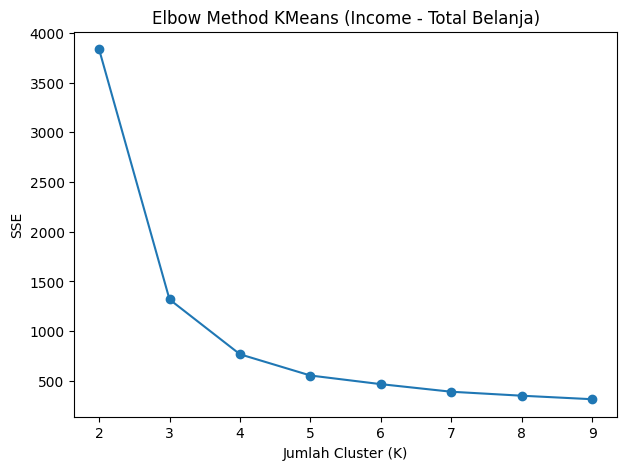

In [78]:
# 13. Elbow method untuk KMeans (hanya 2 fitur)
sse = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(7,5))
plt.plot(K, sse, marker='o')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('SSE')
plt.title('Elbow Method KMeans (Income - Total Belanja)')
plt.show()

KMeans Silhouette Score: 0.5122035712890315
KMeans Davies-Bouldin Index: 0.5435377658277166


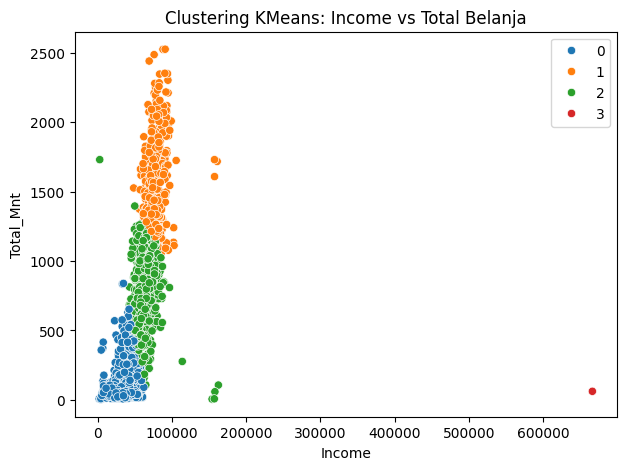

In [79]:
# 14. KMeans clustering + evaluasi
k_opt = 4
kmeans_final = KMeans(n_clusters=k_opt, random_state=42)
labels = kmeans_final.fit_predict(X)
cluster_data['cluster_kmeans'] = labels

print('KMeans Silhouette Score:', silhouette_score(X, labels))
print('KMeans Davies-Bouldin Index:', davies_bouldin_score(X, labels))
# Visualisasi hasil cluster
plt.figure(figsize=(7,5))
sns.scatterplot(x=cluster_data["Income"], y=cluster_data["Total_Mnt"], hue=labels, palette="tab10")
plt.title("Clustering KMeans: Income vs Total Belanja")
plt.show()

DBSCAN Silhouette Score: None
DBSCAN Davies-Bouldin Index: None


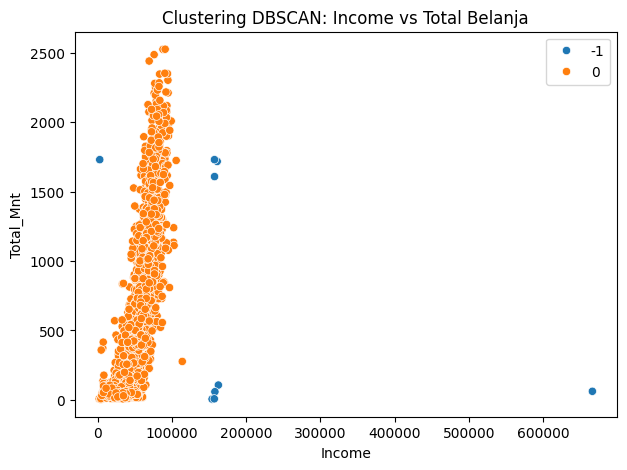

In [80]:
# 15. DBSCAN clustering + evaluasi
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_db = dbscan.fit_predict(X)
cluster_data['cluster_dbscan'] = labels_db
# Evaluasi
mask = labels_db != -1
if sum(mask) > 0 and len(np.unique(labels_db[mask])) > 1:
    sil_score_db = silhouette_score(X[mask], labels_db[mask])
    db_index_db = davies_bouldin_score(X[mask], labels_db[mask])
else:
    sil_score_db = None
    db_index_db = None
print("DBSCAN Silhouette Score:", sil_score_db)
print("DBSCAN Davies-Bouldin Index:", db_index_db)
# Visualisasi
plt.figure(figsize=(7,5))
sns.scatterplot(x=cluster_data["Income"], y=cluster_data["Total_Mnt"], hue=labels_db, palette='tab10')
plt.title("Clustering DBSCAN: Income vs Total Belanja")
plt.show()